#Import libraries and dataset

In [1]:
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/MultiTox.csv')

In [5]:
df

,Unnamed: 0,text,target
0,0,ugli ugli word caus affect mani peopl like lia...,1
1,1,escap orbit assum bad faith rememb time fals c...,0
2,2,show notabl thing order show band meet wp band...,0
3,3,mani peopl would never support pro white caus ...,0
4,4,yeah archiv backward older stuff swap stuff pa...,0
...,...,...,...
624587,624937,see also section nearli alway deprec favor inc...,0
624588,624938,hello dude mother total hot,1
624589,624939,also went televis presidenti elect section rel...,0
624590,624940,otr ticket quot templat give permiss use imag ...,0


In [6]:
df['target'].value_counts()

0    512667
1    111925
Name: target, dtype: int64

#Preprocessing data

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin 

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # for every text in the X list transform its data
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        # return the transformed text list
        return X

    def __normalize(self, text):
        # select only the words, make them lowercase and eliminate \r and \n
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ' '.join([word for word in word_tokenize(text) if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        # getting the hapaxes
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        # eliminating the hapaxes if needed (by default: needed)
        if eliminate:
            text = ' '.join([word for word in word_tokenize(text) if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        # tokenize text's sentences
        for sent in sent_tokenize(text):
            # get the part-of-speech tags of every token of the current sentence
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                # store named entities
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

In [8]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
stopwords = stopwords.words('english')

# create an instance of the transformer class

transformer = TextTransformer(stopwords=stopwords, stemmer=PorterStemmer())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [9]:
X = df['text'].astype('U').values
y = df['target']

In [ ]:
#Preprocessing text fields
X = transformer.transform(X)

#Choosing the model

In [10]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9480098585262667
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    169293
           1       0.89      0.81      0.85     36823

    accuracy                           0.95    206116
   macro avg       0.92      0.89      0.91    206116
weighted avg       0.95      0.95      0.95    206116

Mean Absolute Error: 0.05199014147373324
Mean Squared Error: 0.05199014147373324
Root Mean Squared Error: 0.22801346774638825


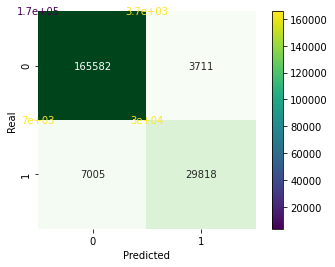

In [12]:
from sklearn.linear_model import LogisticRegression

# creating a pipeline for Logistic Regression
lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X, y) # fitting the model

print(accuracy_score(y_test, lr_pipe.predict(X_test)))

y_pred = lr_pipe.predict(X_test)


plot_confusion_matrix(lr_pipe, X_test, y_test)

print(classification_report(y_test, lr_pipe.predict(X_test))) 

confusion_matrix(y_test.values.reshape(1, -1)[0], y_pred, labels=[0,1])
confusion_matrix = pd.crosstab(y_test.values.reshape(1, -1)[0], y_pred, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lr_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lr_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lr_pipe.predict(X_test))))

ComplementNB

0.889634962836461
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    169293
           1       0.65      0.84      0.73     36823

    accuracy                           0.89    206116
   macro avg       0.81      0.87      0.83    206116
weighted avg       0.91      0.89      0.89    206116

Mean Absolute Error: 0.11036503716353897
Mean Squared Error: 0.11036503716353897
Root Mean Squared Error: 0.3322123374643678


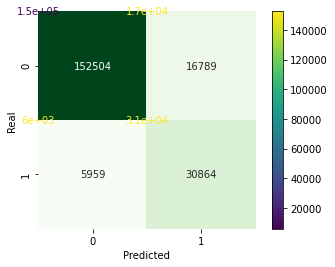

In [ ]:
from sklearn.naive_bayes import ComplementNB
cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

cnb_pipe.fit(X_train, y_train) # fitting the model
print(accuracy_score(y_test, cnb_pipe.predict(X_test)))

y_pred = cnb_pipe.predict(X_test)


plot_confusion_matrix(cnb_pipe, X_test, y_test)

print(classification_report(y_test, cnb_pipe.predict(X_test))) 

confusion_matrix(y_test.values.reshape(1, -1)[0], y_pred, labels=[0,1])
matrix_confusion = pd.crosstab(y_test.values.reshape(1, -1)[0], y_pred, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Greens', cbar=False)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, cnb_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, cnb_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, cnb_pipe.predict(X_test))))

RandomForestClassifier

0.9524733645131868
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    169293
           1       0.89      0.84      0.86     36823

    accuracy                           0.95    206116
   macro avg       0.93      0.91      0.92    206116
weighted avg       0.95      0.95      0.95    206116

Mean Absolute Error: 0.047526635486813254
Mean Squared Error: 0.047526635486813254
Root Mean Squared Error: 0.21800604461072462


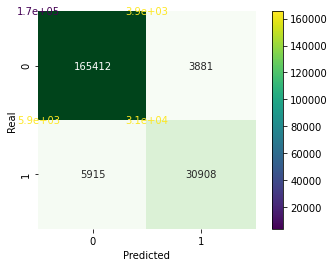

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    RandomForestClassifier(),
)

rf_pipe.fit(X_train, y_train) # fitting the model
joblib.dump(rf_pipe, '/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Random_Forest.pkl')
print(accuracy_score(y_test, rf_pipe.predict(X_test)))

y_pred = rf_pipe.predict(X_test)


plot_confusion_matrix(rf_pipe, X_test, y_test)

print(classification_report(y_test, rf_pipe.predict(X_test))) 

confusion_matrix(y_test.values.reshape(1, -1)[0], y_pred, labels=[0,1])
matrix_confusion = pd.crosstab(y_test.values.reshape(1, -1)[0], y_pred, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Greens', cbar=False)


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rf_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rf_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rf_pipe.predict(X_test))))

#Balanced data

In [ ]:
#Balancing data
df['target'].value_counts()

0    512667
1    111925
Name: target, dtype: int64

In [ ]:
# Underfiting dataset
df_toxic  = df[df['target']==1]
df_non_toxic = df[df['target']==0]
lenght = len(df_toxic)
df_balanced = pd.concat([df_toxic, df_non_toxic.iloc[:lenght]]).sample(frac=1)

In [ ]:
# Get X and y
X_balanced = df_balanced['text'].astype('U').values
y_balanced = df_balanced['target']

In [ ]:
y_balanced.value_counts()

1    111925
0    111925
Name: target, dtype: int64

In [ ]:
#Get another dataset that wasn't used
test_df = pd.read_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/hate_speech.csv')

In [ ]:
test_df

,index,post,label
0,0,simply copy and paste the following text into ...,0
1,1,in order to help increase the booklets downloa...,0
2,2,as of march 13th 2014 the booklet had been dow...,0
3,3,click below for a free download of a colorfull...,1
4,4,click on the download 7 42 mb green banner link,0
...,...,...,...
9920,9920,billy that guy would n t leave me alone so i g...,0
9921,9921,wish we at least had a marine le pen to vote f...,0
9922,9922,its like the choices are white genocide candid...,0
9923,9923,why white people used to say that sex was a si...,1


In [ ]:
test_df['label'].value_counts()

0    8770
1    1155
Name: label, dtype: int64

In [ ]:
test_df= pd.read_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/hate_speech_preprocessed.csv')

In [ ]:
y_test2 = test_df['target']
X_test2 = test_df['text'].values.astype('U')

In [ ]:
# Get X and y and preprocess X 
y_test2 = test_df['label']
X_test2 = test_df['post'].values.astype('U')
X_test2 = transformer.transform(X_test2)


#Saving preprocessed data
data = {'text': X_test2, 'target': y_test2}
dataframe2 = pd.DataFrame(data)
dataframe2.to_csv('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/hate_speech_preprocessed.csv')

0.7228211586901763
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      8770
           1       0.25      0.70      0.37      1155

    accuracy                           0.72      9925
   macro avg       0.60      0.71      0.60      9925
weighted avg       0.87      0.72      0.77      9925

Mean Absolute Error: 0.2771788413098237
Mean Squared Error: 0.2771788413098237
Root Mean Squared Error: 0.5264777690556589


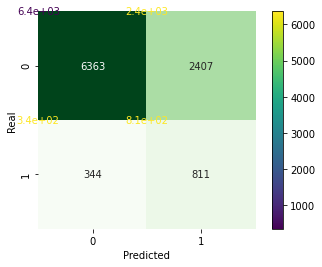

In [ ]:
from sklearn.linear_model import LogisticRegression

# creating a pipeline for Logistic Regression
lr_pipe_balanced = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe_balanced.fit(X_balanced, y_balanced) # fitting the model
joblib.dump(lr_pipe_balanced, '/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Logistic_Regresion_Balanced.pkl')
print(accuracy_score(y_test2, lr_pipe_balanced.predict(X_test2)))

y_pred2 = lr_pipe_balanced.predict(X_test2)


plot_confusion_matrix(lr_pipe_balanced, X_test2, y_test2)

print(classification_report(y_test2, lr_pipe_balanced.predict(X_test2))) 

confusion_matrix(y_test2.values.reshape(1, -1)[0], y_pred2, labels=[0,1])
matrix_confusion = pd.crosstab(y_test2.values.reshape(1, -1)[0], y_pred2, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Greens', cbar=False)



print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2, lr_pipe_balanced.predict(X_test2)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test2, lr_pipe_balanced.predict(X_test2)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, lr_pipe_balanced.predict(X_test2))))

In [ ]:
#Compare how nonX-balanced model will predict this dataset
lr_pipe = joblib.load('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Logistic_Regression_full.pkl')
print('Non-balanced model:')
print(accuracy_score(y_test2, lr_pipe.predict(X_test2)))
print(classification_report(y_test2, lr_pipe.predict(X_test2))) 

Non-balanced model:
0.8574307304785894
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8770
           1       0.39      0.41      0.40      1155

    accuracy                           0.86      9925
   macro avg       0.66      0.66      0.66      9925
weighted avg       0.86      0.86      0.86      9925



0.6486649874055416
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      8770
           1       0.21      0.70      0.32      1155

    accuracy                           0.65      9925
   macro avg       0.57      0.67      0.54      9925
weighted avg       0.86      0.65      0.71      9925

Mean Absolute Error: 0.35133501259445843
Mean Squared Error: 0.35133501259445843
Root Mean Squared Error: 0.5927351960145933


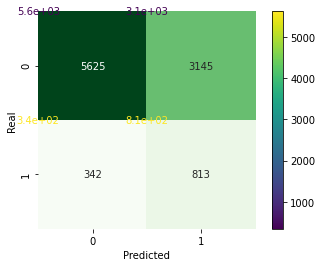

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe_balanced = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    RandomForestClassifier(),
)

rf_pipe_balanced.fit(X_balanced, y_balanced) # fitting the model
joblib.dump(rf_pipe_balanced, '/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Random_Forest_Balanced.pkl')
print(accuracy_score(y_test2, rf_pipe_balanced.predict(X_test2)))

y_pred2 = rf_pipe_balanced.predict(X_test2)


plot_confusion_matrix(rf_pipe_balanced, X_test2, y_test2)

print(classification_report(y_test2, rf_pipe_balanced.predict(X_test2))) 

confusion_matrix(y_test2.values.reshape(1, -1)[0], y_pred2, labels=[0,1])
matrix_confusion = pd.crosstab(y_test2.values.reshape(1, -1)[0], y_pred2, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Greens', cbar=False)



print('Mean Absolute Error:', metrics.mean_absolute_error(y_test2, rf_pipe_balanced.predict(X_test2)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test2, rf_pipe_balanced.predict(X_test2)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test2, rf_pipe_balanced.predict(X_test2))))

Non-balanced model:
0.8274055415617129
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8770
           1       0.27      0.28      0.27      1155

    accuracy                           0.83      9925
   macro avg       0.59      0.59      0.59      9925
weighted avg       0.83      0.83      0.83      9925



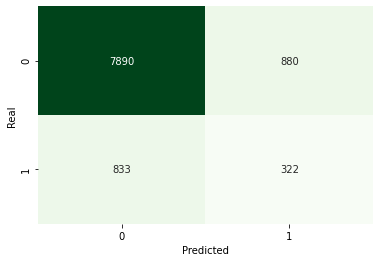

In [ ]:
#Compare how nonX-balanced model will predict this dataset
rf_pipe = joblib.load('/content/drive/MyDrive/Programarea-mea/NLP/Project/Datasets/Random_Forest.pkl')
print('Non-balanced model:')
print(accuracy_score(y_test2, rf_pipe.predict(X_test2)))
print(classification_report(y_test2, rf_pipe.predict(X_test2))) 
y_pred2 = rf_pipe.predict(X_test2)

confusion_matrix(y_test2.values.reshape(1, -1)[0], y_pred2, labels=[0,1])
matrix_confusion = pd.crosstab(y_test2.values.reshape(1, -1)[0], y_pred2, rownames=['Real'], colnames=['Predicted'])
sns.heatmap(matrix_confusion, annot=True, fmt='d', cmap='Greens', cbar=False)